In [1]:
import os
from datetime import datetime, timedelta, timezone
from skyfield.api import load, Topos, EarthSatellite
import matplotlib.pyplot as plt

# all satellite TLE directory
directory = 'TLE_data/'
output_file = "Starlink_TLE/TLE_history.txt"

In [4]:
def parse_tle_epoch(epoch):
    year = int(epoch[:2])
    if year < 57:
        year += 2000
    else:
        year += 1900
    day_of_year = float(epoch[2:])
    day = int(day_of_year)
    fractional_day = day_of_year - day
    date = datetime(year, 1, 1, tzinfo=timezone.utc) + timedelta(days=day - 1)
    time_of_day = timedelta(days=fractional_day)
    return date + time_of_day



# checj if TLE in the time range
def is_tle_in_date_range(tle, start_date, end_date):
    epoch = tle.split()[3]
    tle_time = parse_tle_epoch(epoch)
    return start_date <= tle_time <= end_date

In [5]:
# Dictyionary to store all starlink TLE data
starlink_tle_data = {}

# define time range
start_date = datetime(2024, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2024, 5, 31, tzinfo=timezone.utc)

# search all TLE data in history
for filename in os.listdir(directory):
    if filename.startswith('satellite_TLE'):
        filepath = os.path.join(directory, filename)
        #print(filepath)

        # read file content
        with open(filepath, 'r') as file:
            lines = file.readlines()
            
            # extract starlink satellite TLE
            i = 0
            while i < len(lines):
                if lines[i].startswith('0 STARLINK'):
                    satellite_name = lines[i].strip().split(' ', 1)[1]  # remove the beginning number and space
                    tle1 = lines[i+1].strip()
                    tle2 = lines[i+2].strip()
                    if is_tle_in_date_range(tle1, start_date, end_date):
                        if satellite_name not in starlink_tle_data:
                            starlink_tle_data[satellite_name] = []
                        starlink_tle_data[satellite_name].append(f'{satellite_name}\n{tle1}\n{tle2}\n')
                    i += 3
                else:
                    i += 1

In [7]:
def get_latest_tle(tle_list, target_time):
    latest_tle = None
    latest_time = None
    for tle in tle_list:
        epoch = tle.split()[4]
        #print(epoch)
        tle_time = parse_tle_epoch(epoch)
        if tle_time <= target_time:
            if latest_time is None or tle_time > latest_time:
                latest_tle = tle
                latest_time = tle_time
    return latest_tle

In [8]:
# 定义时间和地点
ts = load.timescale()
columbus = Topos('39.9612 N', '82.9988 W')
target_time = ts.utc(2024, 2, 1, 0, 0, 0)  # 例如2024年5月1日12:00 UTC

# calculate every satellite's azimuth and degree
visible_satellites = []
for satellite_name, tles in starlink_tle_data.items():
    latest_tle = get_latest_tle(tles, target_time.utc_datetime())
    if latest_tle:
        #print(satellite_name)
        satellite = EarthSatellite(latest_tle.split('\n')[1], latest_tle.split('\n')[2], satellite_name, ts)
        difference = satellite - columbus
        topocentric = difference.at(target_time)
        alt, az, distance = topocentric.altaz()

        if alt.degrees > 0:  # 仅显示在地平线以上的卫星
            visible_satellites.append((satellite_name, az.degrees, alt.degrees, distance.km))

In [11]:
len(visible_satellites)

297

In [19]:
# Define location and time series
ts = load.timescale()
columbus = Topos('39.9612 N', '82.9988 W')

start_time = datetime(2024, 1, 1, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 2, tzinfo=timezone.utc)
time_step = timedelta(minutes=3)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

In [25]:
# Initialize all satellite objects
satellites = []
for satellite_name, tles in starlink_tle_data.items():
    latest_tle = get_latest_tle(tles, start_time)
    if latest_tle:
        satellite = EarthSatellite(latest_tle.split('\n')[1], latest_tle.split('\n')[2], satellite_name, ts)
        satellites.append(satellite)


In [26]:
visible_satellites_count = []

# Loop through the time series and calculate visible satellites
for time_point in time_series:
    #print(time_point)
    target_time = ts.utc(time_point.year, time_point.month, time_point.day, time_point.hour, time_point.minute, time_point.second)
    visible_count = 0
    for satellite in satellites:
        difference = satellite - columbus
        topocentric = difference.at(target_time)
        alt, az, distance = topocentric.altaz()

        if alt.degrees > 0:  # Only count satellites above the horizon
            visible_count += 1
    visible_satellites_count.append(visible_count)

In [27]:
time_series[1]-time_series[0]

datetime.timedelta(seconds=180)

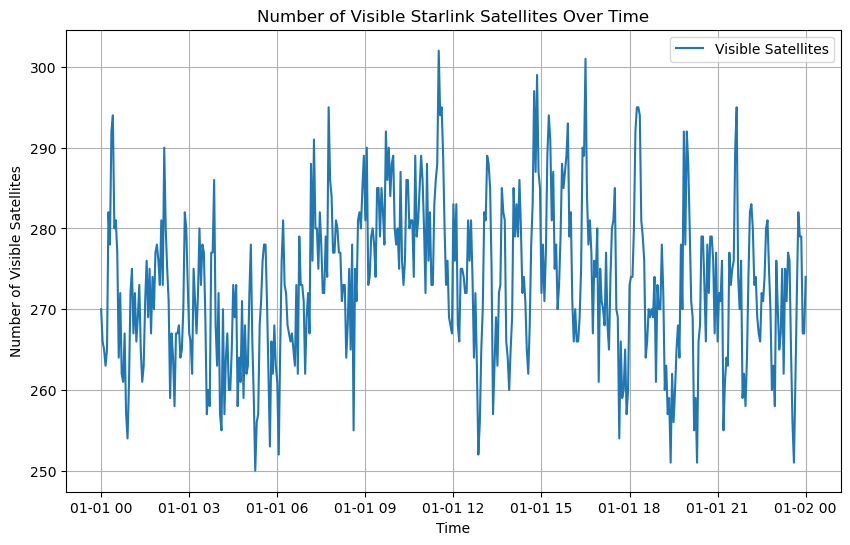

In [28]:
# Plotting the number of visible satellites over time
plt.figure(figsize=(10, 6))
plt.plot(time_series, visible_satellites_count, label='Visible Satellites')
plt.xlabel('Time')
plt.ylabel('Number of Visible Satellites')
plt.title('Number of Visible Starlink Satellites Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
sum(visible_satellites_count)/len(visible_satellites_count)

270.0622786919392

In [24]:
len(time_series)

481

In [30]:
# Define location and time series
ts = load.timescale()
columbus = Topos('39.9612 N', '82.9988 W')

start_time = datetime(2024, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 1, 8, 0, 0, tzinfo=timezone.utc)
time_step = timedelta(minutes=0.1)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

visible_satellites_count = []

# Loop through the time series and calculate visible satellites
for time_point in time_series:
    #print(time_point)
    target_time = ts.utc(time_point.year, time_point.month, time_point.day, time_point.hour, time_point.minute, time_point.second)
    visible_count = 0
    for satellite in satellites:
        difference = satellite - columbus
        topocentric = difference.at(target_time)
        alt, az, distance = topocentric.altaz()

        if alt.degrees > 0:  # Only count satellites above the horizon
            visible_count += 1
    visible_satellites_count.append(visible_count)

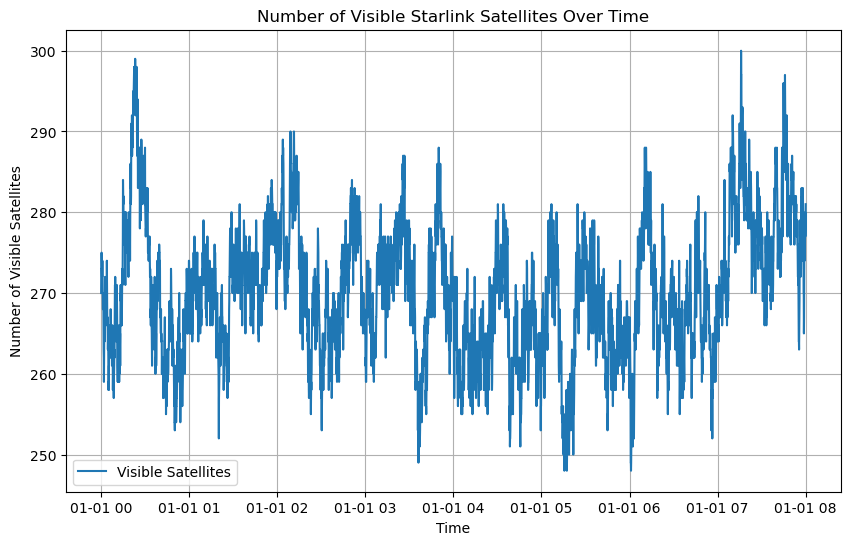

In [31]:
# Plotting the number of visible satellites over time
plt.figure(figsize=(10, 6))
plt.plot(time_series, visible_satellites_count, label='Visible Satellites')
plt.xlabel('Time')
plt.ylabel('Number of Visible Satellites')
plt.title('Number of Visible Starlink Satellites Over Time')
plt.grid(True)
plt.legend()
plt.show()